
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

Project Goals:
----

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

##  Load Dataset and Preproceses Images

### Imports

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

### Constants

In [2]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
PROJECT_SOURCE_URL = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking'
VEHICLES_ZIPFILE = 'vehicles.zip'
NONVEHICLES_ZIPFILE = 'non-vehicles.zip'


## Udacity Dataset Extraction Parameters ##
LABELS_CSV = 'data/object-detection-crowdai/labels.csv'
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
UDACITY_DATASET_DIRECTORY = 'udacity-set'
APPEND_UDACITY_DATASET = True
UDACITY_AUGMENT_PCT = 0.55

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 16 #Prev 32
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 192 # Prev 128
COLOR_SPACE = 'HLS' # Prev HSV
# HOG Parameters
HOG_ORIENTATIONS = 12
HOG_PIXELS_PER_CELL = 10
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

## Training Parameters ##
# SVC Parameters
VALIDATION_PORTION = .1
N_PREDICTIONS = 100
OVERWRITE_DATACACHE = True

### Download and Preprocess Udacity Dataset

In [3]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [4]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join( os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        #print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [5]:
## Download and Extract Training Datasets
# Create Training Set Directories
## Project Datasets
vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,VEHICLES_ZIPFILE), VEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

non_vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,NONVEHICLES_ZIPFILE), NONVEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(non_vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

## Udacity Dataset
tar_file = maybe_download(UDACITY_SOURCE_URL, DATASET_ZIPFILE)
unzip_file(tar_file)

cars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(cars_dir, exist_ok=True)
noncars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'non-vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(os.path.join(noncars_dir, 'skies'), exist_ok=True)
os.makedirs(os.path.join(noncars_dir, 'roads'), exist_ok=True)

In [6]:
## Extract Labels ##
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
annotations = pd.read_csv(LABELS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

,xstart,ystart,xstop,ystop,frame,label,preview_url
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [7]:
def extract_and_preprocess_image(filepath, cars_dir, noncars_dir, xstart, ystart, xstop, ystop,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path):
        # Use cv2 to open image and extract bounding boxes
        img = cv2.imread(full_path)
        # Scale to 0-255 and convert to uint8
        scaled_img = np.uint8(np.copy(img))
        scaled_img = cv2.cvtColor(scaled_img,cv2.COLOR_BGR2RGB)
        img_shape = img.shape
            
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Car Image. Note: numpy arrays are (row, col)!
        car_img = scaled_img[ystart:ystop, xstart:xstop]
        resized_car_img = cv2.resize(car_img, img_size, interpolation=cv2.INTER_AREA)
        im = Image.fromarray(resized_car_img)
        # Save Car Image to corresponding Directory
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', xstart, ystart, xstop, ystop, img_ext)
        im.save(os.path.join(cars_dir, new_filename)) # Save as .png
        im.close
        
        # Auto-Generate a 'Non-Car' Image to keep dataset balanced
        i_lrc = np.random.randint(3) # 66% chance of auto generating non-car features
        if (i_lrc == 0):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                    (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'sky', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir,'skies', new_filename)
        elif (i_lrc == 1):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, ystop, xstop, \
                                                    (img_shape[0] if ystop+(ystop-ystart) > img_shape[0] else ystop+(ystop-ystart))
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'road', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir, 'roads', new_filename)
            
        noncar_img = scaled_img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_noncar_img = cv2.resize(noncar_img, img_size, interpolation=cv2.INTER_AREA)
        # Save noncar image to corresponding Directory
        im = Image.fromarray(resized_noncar_img)
        filename, ext = os.path.splitext(filepath)
        im.save(path_file) # Save as .png
        im.close

In [8]:
## Extract Labels ##      
for label in annotations.as_matrix():
    filename, ext = os.path.splitext(label[4])
    new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', label[0], label[1], label[2], label[3], '.png')
    if not os.path.exists(os.path.join(cars_dir, new_filename)) and label[5].lower() == 'car':
        try:
            extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
                                     xstop=label[2], ystop=label[3])
        except:
            print("Error extracting label:", label, " Moving on..")

Error extracting label: [912 0 951 0 '1479498564477313399.jpg' 'Car'
 'http://crowdai.com/images/k-zz9yqpJIit7OuX/visualize']  Moving on..
Error extracting label: [705 0 732 0 '1479498820473341507.jpg' 'Car'
 'http://crowdai.com/images/Ng_nd_wBlqkgNDGb/visualize']  Moving on..
Error extracting label: [721 0 751 0 '1479499937073018706.jpg' 'Car'
 'http://crowdai.com/images/sbjD-93YWUi9hJ0c/visualize']  Moving on..


## Extract Features from Dataset

### Helper Functions

In [9]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


In [10]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [11]:
# Define a function to return HOG features and visualization --
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):      
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [12]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    # Create a list to append feature vectors
    features = []
    for file in imgs:       
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Need to convert to RGB
        # Image read in from cv2 + .png -> (0 to 255) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(img)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
        if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features, hist_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((hist_features)))
        else:
            features.append(np.concatenate(feature_image))
        
    # Return list of feature vectors
    return features

### Begin Training Pipeline

In [41]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
udacity_cars = []
udacity_notcars = []
for image in images:
    if UDACITY_DATASET_DIRECTORY in image:
        if NON_VEHICLES_TOKEN in image:
            udacity_notcars.append(image)
        else:
            udacity_cars.append(image)
    else:
        if NON_VEHICLES_TOKEN in image:
            notcars.append(image)
        else:
            cars.append(image)

assert len(images) == len(cars) + len(notcars) + len(udacity_cars) + len(udacity_notcars), 'The subarrays have not split the dataset correctly.'
print('Number of Vehicle Images Found:',len(cars))
print('Number of Non-Vehicle Images Found:',len(notcars))
    
if APPEND_UDACITY_DATASET == True: #Using to Keep Dataset separate
    udacity_augment_size = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    ind = np.random.random_integers(0, len(udacity_cars)-1, udacity_augment_size)
    cars.extend(list(udacity_cars[ind]))
    ind = np.random.random_integers(0, len(udacity_notcars)-1, udacity_augment_size)
    notcars.extend(list(udacity_notcars[ind]))
else:
    num_udacity_features = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    udacity_features_ind = np.random.randint(0, len(udacity_cars), size=num_udacity_features)
    udacity_cars = list(udacity_cars[udacity_features_ind])
    udacity_features_ind = np.random.randint(0, len(udacity_notcars), size=num_udacity_features)
    udacity_notcars = list(udacity_notcars[udacity_features_ind])
    
    
print('Number of Udacity Vehicle Images Found:',len(udacity_cars))
print('Number of Udacity Non-Vehicle Images Found:',len(udacity_notcars))
print('')
print('Size of Vehicle Images Dataset:',len(cars))
print('Size of Non-Vehicle Images Dataset:',len(notcars))

Number of Vehicle Images Found: 8792
Number of Non-Vehicle Images Found: 8968
Number of Udacity Vehicle Images Found: 62567
Number of Udacity Non-Vehicle Images Found: 63997

Size of Vehicle Images Dataset: 43203
Size of Non-Vehicle Images Dataset: 43379


Feature Vector size for Cars: 4944
Using Spatial Binning of: 16 and 192 histogram bins


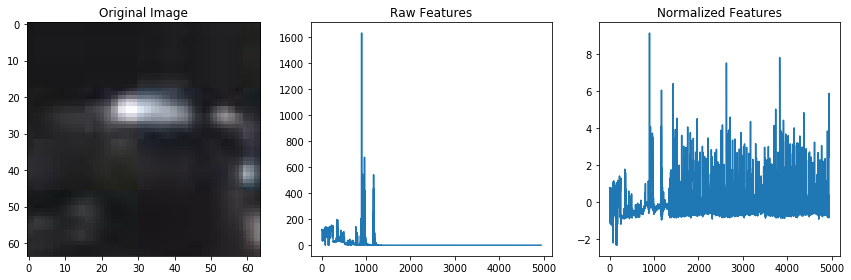

In [14]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Seperately Extract Feature from Udacity Dataset
if APPEND_UDACITY_DATASET == False:
    udacity_car_features = extract_features(udacity_cars)
    udacity_notcar_features = extract_features(udacity_notcars)
    
# Create an array stack of feature vectors
X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')

In [15]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 4944


### Train using  Support Vector Classifier

In [17]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

401.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9363
SVC predicts:  [ 0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
For these 100 labels:  [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.
  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
0.0208 Seconds to predict 100 labels with SVC


In [18]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY, 
                      override_datacache=OVERWRITE_DATACACHE):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if override_datacache or not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_SCALER':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL,
                               'SW_SPATIAL_FEAT_FLAG': SW_SPATIAL_FEAT_FLAG,
                               'SW_HOG_FEAT_FLAG': SW_HOG_FEAT_FLAG,
                               'SW_COLOR_HIST_FEAT_FLAG': SW_COLOR_HIST_FEAT_FLAG
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Vehicle Detection and Tracking

### Re-Initialize Imports

In [19]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Re-initialize Constants from Pickle File

In [57]:
## Directories ##
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'
testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')
with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
## Feature Extraction Parameters ##
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_SCALER']
# Spatial Binning
SW_SPATIAL_FEAT_FLAG = svc_hyperparameters['SW_SPATIAL_FEAT_FLAG'] 
SPATIAL = svc_hyperparameters['SPATIAL']
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
SW_COLOR_HIST_FEAT_FLAG = svc_hyperparameters['SW_COLOR_HIST_FEAT_FLAG']
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
SW_HOG_FEAT_FLAG = svc_hyperparameters['SW_HOG_FEAT_FLAG']
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL']

## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (None, None)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(64, 64), (96,96),(128,128)]
SW_XY_OVERLAPS = [(0.50, 0.50),(.50,.50),(.50,.50)] 

## Vehicle Detection Parameters ##
BBOX_COLOR = (0, 255, 0)
BBOX_THICK = 5

## Explore Detection Technique (1) - Sliding Windows 

In [21]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [22]:
# Define a wrapper function for passing in a list of slidw_window parameters
def slide_windows(img, x_start_stops=[[None, None]],
                  y_start_stops=[[None, None]],
                  xy_windows=[(64, 64)],
                  xy_overlaps=[(0.5, 0.5)]):
    windows = []
    for i in range(len(x_start_stops)):
        if len(x_start_stops) == len(xy_windows) and len(x_start_stops) == len(xy_overlaps):
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[i]), np.asarray(xy_overlaps[i]))
        else:
            windows = slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[0]), np.asarray(xy_overlaps[0]))
    return windows

In [23]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None],
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    window_list=[]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None or x_start_stop[1] >= img.shape[1]:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None or y_start_stop[1] >= img.shape[0]:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [24]:
#Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [25]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, 
                        spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, 
                        orient=HOG_ORIENTATIONS, 
                        pix_per_cell=HOG_PIXELS_PER_CELL, 
                        cell_per_block=HOG_CELLS_PER_BLOCK,
                        hog_channel=HOG_CHANNEL, 
                        spatial_feat=SW_SPATIAL_FEAT_FLAG,
                        hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                        hog_feat=SW_HOG_FEAT_FLAG):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    # Scale Image for feature extraction?
    #feature_image = feature_image.astype(np.float64)
    #feature_image = np.float64(np.copy(feature_image))
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [26]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc=SVC, 
                   X_scaler=X_SCALER, 
                   color_space=COLOR_SPACE, 
                   spatial_size=BIN_SPATIAL_SIZE, 
                   hist_bins=HIST_NBINS, 
                   orient=HOG_ORIENTATIONS, 
                   pix_per_cell=HOG_PIXELS_PER_CELL, 
                   cell_per_block=HOG_CELLS_PER_BLOCK, 
                   hog_channel=HOG_CHANNEL, 
                   spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                   hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                   hog_feat=SW_HOG_FEAT_FLAG):
            
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    heatmap = np.zeros_like(img[:,:,0])    
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (DEFAULT_LENGTH, DEFAULT_WIDTH)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(list(np.array(features).reshape(1, -1)))
        #6) Predict using classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1

    #8) Return windows for positive detections
    return on_windows, heatmap
    

In [27]:
# Try Scaling Windows on Test Images
image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_single_frame_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for label in labels:
        for car_number in range(1, label[1] + 1):
            #Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            #Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            #Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICK)
        # Return the image
    return img

BBoxes Found: 45
1.8002336025238037 seconds to process one image search 351 windows
BBoxes Found: 35
1.8194448947906494 seconds to process one image search 351 windows
BBoxes Found: 26
1.7953975200653076 seconds to process one image search 351 windows
BBoxes Found: 22
1.7994015216827393 seconds to process one image search 351 windows
BBoxes Found: 40
1.7951605319976807 seconds to process one image search 351 windows
BBoxes Found: 25
1.7789034843444824 seconds to process one image search 351 windows


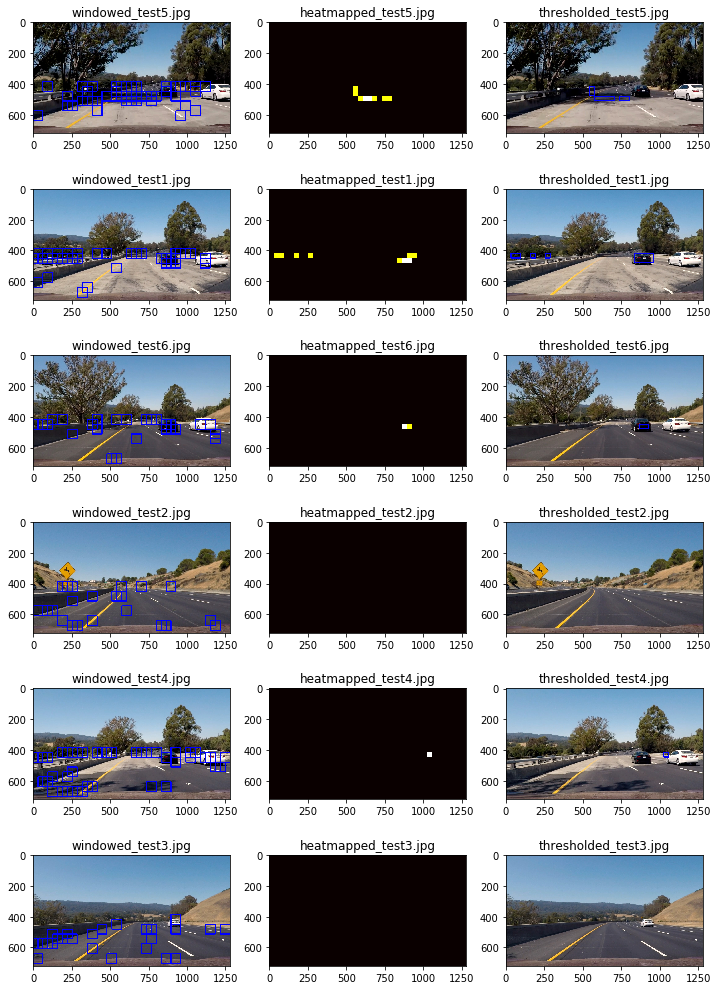

In [29]:
# Define a single function that can extract features using sliding windows and make predictions
carslist = []
out_images = []
out_titles = []

for img_path in image_paths:
    t1 = time.time()
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_shape = img.shape
    draw_img = np.copy(rgb_img)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    threshold = 2
    filename = os.path.split(img_path)[-1]
    
    windows = slide_windows(rgb_img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
    
    hot_windows, heatmap = search_windows(rgb_img, windows)
    print('BBoxes Found:', len(hot_windows))
    
    window_img = draw_boxes(rgb_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    labels = label(apply_threshold(heatmap, threshold))
    
    # Draw bounding boxes on a copy of the input image       
    window_img_thresh = draw_single_frame_labeled_bboxes(draw_img, [labels])

    out_images.append(window_img)
    out_titles.append('windowed_'+filename)
    out_images.append(heatmap)
    out_titles.append('heatmapped_'+filename)
    out_images.append(window_img_thresh)
    out_titles.append('thresholded_'+filename)
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, out_images, out_titles)

## Explore Vehicle Dectection Technique (2) - HOG Sub-Sampling Window Search 

We want a more efficient way to detect vehicles. This approach will allow for only a single call to get HOG features. The pipeline will then find a sub sample

In [30]:
SW_CONVERT_COLOR = 'RGB2YCrCb'
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

0.17902708053588867 seconds to run, total windows =  5
0.1855311393737793 seconds to run, total windows =  10
0.19152355194091797 seconds to run, total windows =  15
0.19762349128723145 seconds to run, total windows =  20
0.20352673530578613 seconds to run, total windows =  25
0.20944762229919434 seconds to run, total windows =  30
0.21535110473632812 seconds to run, total windows =  35
0.22123003005981445 seconds to run, total windows =  40
0.22709417343139648 seconds to run, total windows =  45
0.2330782413482666 seconds to run, total windows =  50
0.23897767066955566 seconds to run, total windows =  55
0.2448580265045166 seconds to run, total windows =  60
0.2507812976837158 seconds to run, total windows =  65
0.2567436695098877 seconds to run, total windows =  70
0.2626018524169922 seconds to run, total windows =  75
0.26848602294921875 seconds to run, total windows =  80
0.27440929412841797 seconds to run, total windows =  85
0.28034257888793945 seconds to run, total windows =  90

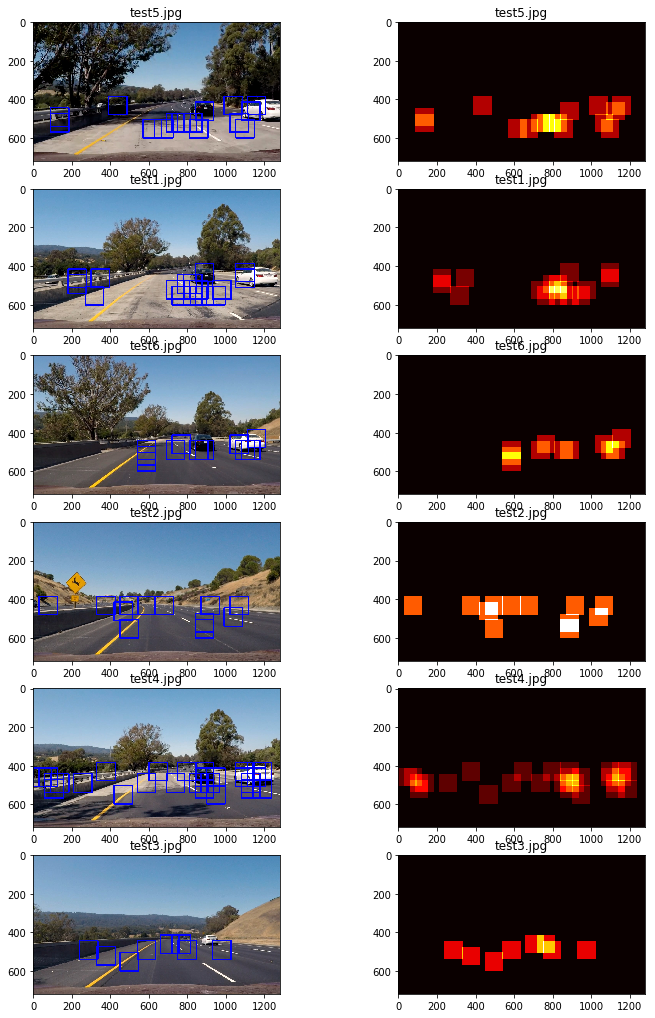

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
out_images = []
out_maps = []
out_titles = []
out_boxes = []

## Parameters - HOG Sub-Sampling ##
 

ystart = SW_YSTART
ystop = SW_YSTOP
scale = SW_SCALE
spatial_size=BIN_SPATIAL_SIZE
hist_bins=HIST_NBINS
orient=HOG_ORIENTATIONS
pix_per_cell=HOG_PIXELS_PER_CELL
cell_per_block=HOG_CELLS_PER_BLOCK
hog_channel=HOG_CHANNEL
spatial_feat=SW_SPATIAL_FEAT_FLAG
hog_feat=SW_HOG_FEAT_FLAG
hist_feat=SW_COLOR_HIST_FEAT_FLAG


#Iterate over the test images
for img_path in image_paths:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            if SW_HOG_FEAT_FLAG == True: # Should always be true
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            if SW_SPATIAL_FEAT_FLAG == True:
                spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            if SW_COLOR_HIST_FEAT_FLAG == True:    
                hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
                        
            # Append the new feature vector to the features list
            # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
            if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features, hist_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((hist_features))
            else:
                test_feats = np.hstack((np.ravel(img)))
            
            
            # Scale features and make a prediction
            test_features = X_SCALER.transform(test_feats.reshape(1, -1))
            test_prediction = SVC.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
        print(time.time()-t1, 'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(os.path.split(img_path)[-1])
    out_titles.append(os.path.split(img_path)[-1])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [32]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=SW_YSTART,
              ystop=SW_YSTOP, 
              scale=SW_SCALE, 
              svc=SVC, 
              X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, 
              pix_per_cell=HOG_PIXELS_PER_CELL, 
              cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, 
              hist_bins=HIST_NBINS,
              spatial_feat=SW_SPATIAL_FEAT_FLAG,
              hog_feat=SW_HOG_FEAT_FLAG,
              hist_feat=SW_COLOR_HIST_FEAT_FLAG):
    
    # If y start/stop positions not defined, set to image size      
    if ystart == None or ystart < 0:
        ystart = 384
    if ystop == None or ystop > img.shape[0]:
        ystop = img.shape[0]
    draw_img = np.copy(img)

    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_to_search = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64 # 10 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
    cells_per_step = 1 # HOG_CELLS_PER_BLOCK  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this particular patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

            # Get color features
            if SW_SPATIAL_FEAT_FLAG == True:
                spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
            if SW_COLOR_HIST_FEAT_FLAG == True:    
                hist_features = color_hist(subimg, nbins=HIST_NBINS)
            
                        
            # Append the new feature vector to the features list
            # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
            if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hist_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                test_feats = np.hstack((spatial_features, hog_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features))
            elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((spatial_features, hist_features))
            elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                test_feats = np.hstack((hist_features))
            else:
                test_feats = np.hstack((np.ravel(img)))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(test_feats.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,BBOX_THICK)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap

In [33]:
# DEFINE A CLASS TO RECEIVE THE CHARACTERISTICS OF EACH VEHICLE DETECTION
# Objects defined as "Vehicles" will be where multiple overlaping detections exists in the heatmap
class Vehicle():
    def __init__(self, bbox):
        self.prev_detected = False # Flag sets if the Vehicle was detected in the last iteration
        self.cur_detected = True # Flag sets if the Vehicle is detected in the current iteration
        self.n_detections = 1 # number of times this vehicle has been detected
        self.n_non_detections = 0 # number of consecutive times this vehicle has not been detected
        self.xpixels = np.arange(bbox[0][0], bbox[1][0]+1) # Pixel x values of last detection
        self.ypixels = np.arange(bbox[0][1], bbox[1][1]+1) # Pixel y values of last detection
        self.recent_xfitted = []
        self.recent_xfitted.append(bbox[0][0]) # x position of the last n fits of the bounding box
        self.bestx = bbox[0][0] # X position of the current fit
        self.recent_yfitted = []
        self.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
        self.besty = bbox[0][1] # Average y position of the current fit
        self.recent_wfitted = []
        self.recent_wfitted.append(bbox[1][0])
        self.bestw = bbox[1][0] # Average width of the last n fits
        self.recent_hfitted = []
        self.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
        self.besth = bbox[1][1] # Average height of the last n fits
        self.bounding_box = bbox

In [49]:
# Define a function that Implements Smoothing Factor for Multi-Fram Object Tracking
def draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=1, keep_weight=10, remove_threshold = 7, debug=False):
    img = np.copy(img)
    # Set all cur_detected values to false for current frame
    for car in carslist:
        car.cur_detected = False
    
    for label in labels:
        # Iterate through all detected labels
        for car_number in range(1, label[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Check if bounding box appears in carslist
            found_match = False
            for car in carslist:               
                # Create comparison matrix
                bbox_flatten = []
                bbox_flatten.append(bbox[0])
                bbox_flatten.append(bbox[1])
                bbox_flatten = [x for xs in bbox_flatten for x in xs]
                
                car_bbox_flat = []
                car_bbox_flat.append(car.bounding_box[0])
                car_bbox_flat.append(car.bounding_box[1])
                car_bbox_flat = [x for xs in car_bbox_flat for x in xs]
                
                if(np.allclose(bbox_flatten, car_bbox_flat, atol=8)):
                    found_match = True
                    if debug:
                        print('Found a match. Car Bounding Box', car.bounding_box, '| length nonzerox:',len(nonzerox),
                             '| length nonzeroy:',len(nonzeroy))
                        print('Checked against Bounding box:',bbox)

                    car.n_detections += 1                
                    car.prev_detected = found_match
                    car.cur_detected = found_match
                    car.n_non_detections = 0 # Reset non_detections value
                    car.xpixels = nonzerox # Pixel x values of current detection
                    car.ypixels = nonzeroy # Pixel y values of current detection
                    if car.n_detections > keep_weight: # Average last x values to keep best points current
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted[:-keep_weight])) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted[:-keep_weight])) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted[:-keep_weight])) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted[:-keep_weight])) # Average height of the last n fits
                    else:
                        car.recent_xfitted.append(bbox[0][0])
                        car.bestx = int(np.mean(car.recent_xfitted)) # Average x position of the last n fits
                        car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                        car.besty = int(np.mean(car.recent_yfitted)) # Average y position of the current fit
                        car.recent_wfitted.append(bbox[1][0])
                        car.bestw = int(np.mean(car.recent_wfitted)) # Average width of the last n fits
                        car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                        car.besth = int(np.mean(car.recent_hfitted)) # Average height of the last n fits

                    car.bounding_box = ((car.bestx, car.besty),
                                            (car.bestw, car.besth))
                    break

            # After searching for existing car, add new Vehicle         
            if found_match == False and len(nonzerox) > 1e2 and len(nonzeroy) < 1e5: 
                # Add New Vehicle
                car = Vehicle(bbox)
                car.xpixels = nonzerox
                car.ypixels = nonzeroy
                car.n_non_detections +=1 
                car.prev_detected = found_match
                car.cur_detected = True

                # Add car to carslist
                carslist.append(car)
            
        
    # After searching through labels and updating carslist, draw labels
    for car in carslist:
        # Set n_non_detections+=1 for each car in carslist that wasn't prev_detected
        if (car.prev_detected == True and car.cur_detected == False):
            if debug:
                print('Found possible false positive for car:', car.bounding_box, 'checking against smoothing factor')
            car.prev_detected == False
            car.n_non_detections +=1
        
        ## Apply noise filtering to object detections
        #Process cars within the smoothing factor range
        if (car.n_detections > smoothing_factor \
            and car.n_detections > car.n_non_detections #prev had this as an or
            and len(car.xpixels) > 1e2
            and len(car.ypixels) < 1e5):
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
        
        if (car.n_non_detections > remove_threshold \
            or len(car.xpixels) < 1e2):
            if debug: print('Removing Car:', car.bounding_box)
            carslist.remove(car)
        
    # Return the image
    return img

In [ ]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
carslist = []
threshold = 10

## Parameters - HOG Sub-Sampling ##
SW_YSTART = 384
SW_YSTOP = 672
SW_SCALE = 1.5

#Iterate over the test images
for img_path in image_paths:
    img = mpimg.imread(img_path)
    out_img, heatmap = find_cars(img, ystart=SW_YSTART, 
                                 ystop=SW_YSTOP, 
                                 scale=SW_SCALE)
    labels = label(apply_threshold(heatmap, threshold))
    # Draw bounding boxes on a copy of the image       
    draw_img = draw_single_frame_labeled_bboxes(np.copy(out_img), [labels])
    out_images.append(draw_img)
    out_images.append(heatmap)
    filename = os.path.split(img_path)[-1]
    out_titles.append(filename)
    out_titles.append(filename)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [59]:
## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(None, None), (None, None)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(64, 64), (96,96),(128,128)]
SW_XY_OVERLAPS = [(0.50, 0.50),(.50,.50),(.50,.50)] 

def process_image(img):
    if (img is not None):
        labels = []
        ## Search for cars from previous frame Gather previous bboxes from carslist
        heatmap_1 = np.zeros_like(img[:,:,2])
        img = np.copy(img)
        
        ## Search for previously detected cars in current frame ##
        bboxes = [[(500, 375), (750, 480)]] #Start with window presumed to be in front of vehicle
        for car in carslist:
            bboxes.append(list(car.bounding_box))
            
        detected_cars_threshold = 3
        _, heatmap_1 = search_windows(img, bboxes)
        labels.append(label(apply_threshold(heatmap_1, detected_cars_threshold)))
        
        ## Detect with HOG subsampling ##
        hog_subsampling_threshold = 5
        _, heatmap_2 = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALE)
        labels.append(label(apply_threshold(heatmap_2, hog_subsampling_threshold)))
        
        ## Detect with Sliding Windows ##
        sliding_windows_threshold = 6
        windows = slide_windows(img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
        _, heatmap_3 = search_windows(img, windows)
        labels.append(label(apply_threshold(heatmap_3, sliding_windows_threshold)))

        #combined_heatmap = np.add(heatmap_1, heatmap_2, heatmap_3)
        #thresholded_labels = label(apply_threshold(combined_heatmap, 1))
        draw_img = draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=2, debug=False)
        return draw_img
    else:
        return img

In [60]:
#Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_ouput = 'test_output.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)
clip = VideoFileClip(VIDEO_FILE_PATH)
carslist = []
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

[MoviePy] >>>> Building video data/test_output.mp4
[MoviePy] Writing video data/test_output.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:05<03:15,  5.13s/it]

  5%|▌         | 2/39 [00:10<03:09,  5.11s/it]

  8%|▊         | 3/39 [00:15<03:04,  5.11s/it]

 10%|█         | 4/39 [00:20<02:58,  5.11s/it]

 13%|█▎        | 5/39 [00:25<02:54,  5.13s/it]

 15%|█▌        | 6/39 [00:30<02:51,  5.19s/it]

 18%|█▊        | 7/39 [00:36<02:49,  5.28s/it]

 21%|██        | 8/39 [00:42<02:46,  5.38s/it]

 23%|██▎       | 9/39 [00:48<02:46,  5.56s/it]

 26%|██▌       | 10/39 [00:53<02:42,  5.59s/it]

 28%|██▊       | 11/39 [00:59<02:38,  5.65s/it]

 31%|███       | 12/39 [01:05<02:34,  5.72s/it]

 33%|███▎      | 13/39 [01:11<02:30,  5.80s/it]

 36%|███▌      | 14/39 [01:17<02:25,  5.83s/it]

 38%|███▊      | 15/39 [01:23<02:21,  5.91s/it]

 41%|████      | 16/39 [01:29<02:17,  5.97s/it]

 44%|████▎     | 17/39 [01:35<02:11,  5.99s/it]

 46%|████▌     | 18/39 [01:41<02:08,  6.13s/it]

 49%|████▊     | 19/39 [01:48<02:06,  6.31s/it]

 51%|█████▏    | 20/39 [01:55<02:01,

[MoviePy] Done.
[MoviePy] >>>> Video ready: data/test_output.mp4 



### Process Project Video

In [48]:
project_ouput = 'project_output.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, project_ouput)

carslist = []
clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

[MoviePy] >>>> Building video data/project_output.mp4
[MoviePy] Writing video data/project_output.mp4



  3%|▎         | 39/1261 [04:07<2:36:59,  7.71s/it]

KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))